# PART 2 - Mapping and Visualizing Hurricanes from NEXRAD Archived Data

The [NEXRAD data](https://aws.amazon.com/noaa-big-data/nexrad/) is a public dataset hosted on amazon. It contains historical records of 160 NEXRAD radars across the US from 1990 to today.

### CartoDB great tool for mapping radar data

![](image/download.png)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as mdates
import os
import boto3
import numpy.ma as ma
import pyart.graph
import tempfile
import pyart.io
import geopy
import math
import re
import csv
import pyart
from subprocess import call

### Connect to Historical Data S3 Bucket

In [8]:
LOCAL_PATH = "/home/alces/data/"
s3c = boto3.client('s3')
bucket = "noaa-nexrad-level2"

## Hurricane Katrina: New Orleans 2005/08/29/  10:10am
### Load NEXRAD file from public S3 bucket

In [9]:
key = "2005/08/29/KLIX/KLIX20050829_101013.gz"
download_path = LOCAL_PATH + key.replace("/","_")

s3c.download_file(bucket, key, download_path)
data = pyart.io.read_nexrad_archive(download_path)

/Users/marvinbertin/anaconda/lib/python2.7/site-packages/pyart/io/nexrad_archive.py:203: UserWarning: Gate spacing is not constant, interpolating data in scans [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] for moment REF.
  UserWarning)


### Plotting Helper Function

In [10]:
def plot_nexrad(data, vmin=None, vmax=None, xlims=None, ylims=None):
    '''Create a plot'''
    # Create a PyArt radar instance
    fig, ax = plt.subplots()
    #ax = plt.axes()
    d = pyart.graph.RadarDisplay(data)
    d.plot('reflectivity',0, vmin=vmin, vmax=vmax, cmap="pyart_Carbone42")
    if xlims is None:
        xlims = (-250., 250)
    if ylims is None:
        ylims = (-250., 250)
    d.set_limits(xlims, ylims)       

### Hurricane Katrina Reflectivity Plot

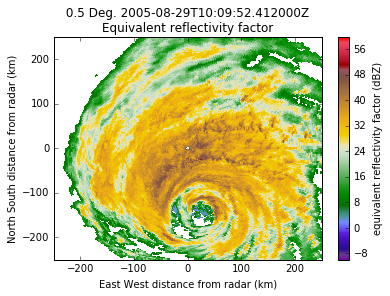

In [12]:
plot_nexrad(data, vmin=-10, vmax=60.)

## Hurricane Sandy: 2012/10/09 3:21pm
**More recent NEXRAD archives contain richer data. This makes possible the analysis of new weather dimensions.** 
### Load NEXRAD file from public S3 bucket

In [13]:
# (29 October 2012) Hurricane Sandy
key = "2012/10/29/KDOX/KDOX20121029_152101_V07.gz"
download_path = LOCAL_PATH + key.replace("/","_")

s3c.download_file(bucket, key, download_path)
data = pyart.io.read_nexrad_archive(download_path)

### Plot Multiple Variables from New NEXRAD Data

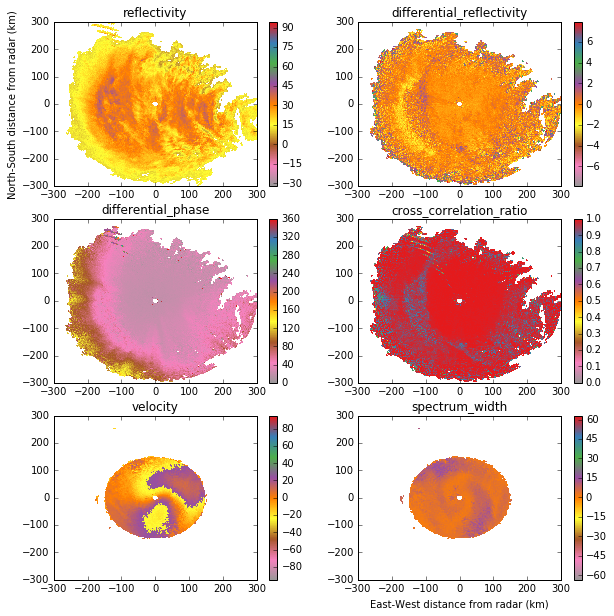

In [16]:
# display the lowest elevation scan data
display = pyart.graph.RadarDisplay(data)
fig = plt.figure(figsize=(10, 10))

plots = [
    # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
    ['reflectivity', 'Reflectivity (dBZ)', 0],
    ['differential_reflectivity', 'Zdr (dB)', 0],
    ['differential_phase', 'Phi_DP (deg)', 0],
    ['cross_correlation_ratio', 'Rho_HV', 0],
    ['velocity', 'Velocity (m/s)', 1],
    ['spectrum_width', 'Spectrum Width', 1]
]

for plotno, plot in enumerate(plots, start=1):
    ax = fig.add_subplot(3, 2, plotno)
    display.plot(plot[0], plot[2], ax=ax, title=plot[0],
             colorbar_label='',
             axislabels=('East-West distance from radar (km)' if plotno == 6 else '', 
                         'North-South distance from radar (km)' if plotno == 1 else ''),
             cmap= plt.cm.Set1_r)
    display.set_limits((-300, 300), (-300, 300), ax=ax)

plt.show()

### Apply Basic Quality Control on Reflectivity

In [17]:
refl_grid = data.get_field(0, 'reflectivity')
print(refl_grid[0])
rhohv_grid = data.get_field(0, 'cross_correlation_ratio')
zdr_grid = data.get_field(0, 'differential_reflectivity')

# apply quality control
reflow = np.less(refl_grid, 20)
zdrhigh = np.greater(np.abs(zdr_grid), 2.3)
rhohvlow = np.less(rhohv_grid, 0.95)
notweather = np.logical_or(reflow, np.logical_or(zdrhigh, rhohvlow))
print(notweather[0])

qcrefl_grid = ma.masked_where(notweather, refl_grid)
print(qcrefl_grid[0])

[-- -- -- ..., -- -- --]
[-- -- -- ..., -- -- --]
[-- -- -- ..., -- -- --]


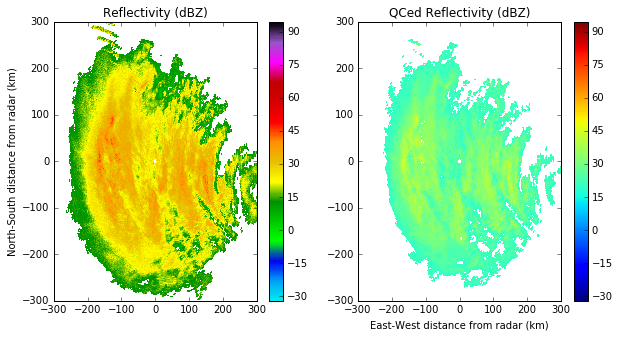

In [18]:
# let's create a new object containing only sweep=0 so we can add the QC'ed ref to it for plotting
qced = data.extract_sweeps([0])
qced.add_field_like('reflectivity', 'reflectivityqc', qcrefl_grid)
display = pyart.graph.RadarDisplay(qced)
fig = plt.figure(figsize=(10, 5))

plots = [
    # variable-name in pyart, display-name that we want, sweep-number of radar (0=lowest ref, 1=lowest velocity)
    ['reflectivity', 'Reflectivity (dBZ)', 0],
    ['reflectivityqc', 'QCed Reflectivity (dBZ)', 0],
]

for plotno, plot in enumerate(plots, start=1):
    ax = fig.add_subplot(1, 2, plotno)
    display.plot(plot[0], plot[2], ax=ax, title=plot[1],
             colorbar_label='',
             axislabels=('East-West distance from radar (km)' if plotno == 2 else '', 
                         'North-South distance from radar (km)' if plotno == 1 else ''))
    display.set_limits((-300, 300), (-300, 300), ax=ax)

plt.show()